In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import scotia
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.spatial import distance_matrix
from scipy.stats import ranksums
from matplotlib.collections import LineCollection
from statsmodels.stats.multitest import multipletests
import warnings
from random import shuffle
warnings.filterwarnings("ignore")
import sys


In [4]:
datap = '/your/workspace/'

In [8]:
#get DBSCAN cell clusters
sample_id = 'bregma_0.01'
sample_id = 'bregma_-0.09'
meta_df_fov = pd.read_csv(datap+'data/merfish_'+sample_id+'.csv',index_col=0)
celltype = []
cell_idx = []
meta_df_fov['index'] = range(meta_df_fov.shape[0])

cell_type_l = list(set(meta_df_fov['Cell_class']))
for ct in cell_type_l:
#for ct in ['Excitatory']:
    ###cluster cells
    #print(ct)
    meta_df_sel = meta_df_fov[meta_df_fov['Cell_class']==ct]
    X = np.array(meta_df_sel[['Centroid_X','Centroid_Y']])
    if X.shape[0] >= 10:
        print(ct)
        idx_l, fi_eps = scotia.dbscan_ff_cell(X, X_index_arr=np.array(meta_df_sel['index']),eps_l = list(range(1,500,5)))
        #idx_l, fi_eps = scotia.dbscan_ff_cell(X, X_index_arr=np.array(meta_df_sel['index']))
        if len(idx_l)>0:
            celltype += [ct for x in idx_l]
            cell_idx += idx_l
tmp_df = pd.DataFrame([celltype,cell_idx]).T
np.save(datap+'output/clustering/'+sample_id+'_dbscan.cell.clusters.test2',tmp_df)

Inhibitory
eps: 46
Excitatory
eps: 86
Pericytes
eps: 121
Ependymal
eps: 46
Microglia
eps: 216
Endothelial 3
eps: 206
OD Immature 1
eps: 156
Endothelial 2
eps: 276
OD Mature 1
eps: 496
Ambiguous
eps: 66
OD Immature 2
eps: 396
Astrocyte
eps: 86
OD Mature 4
eps: 221
OD Mature 2
eps: 101
Endothelial 1
eps: 131


Inhibitory


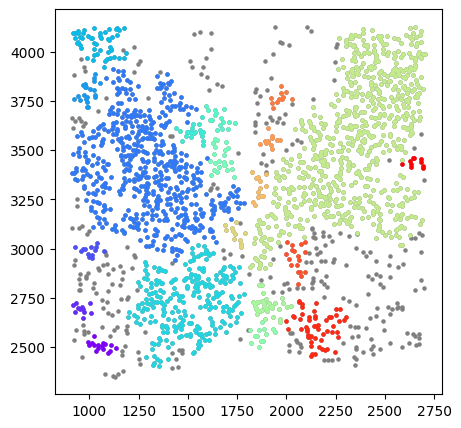

Excitatory


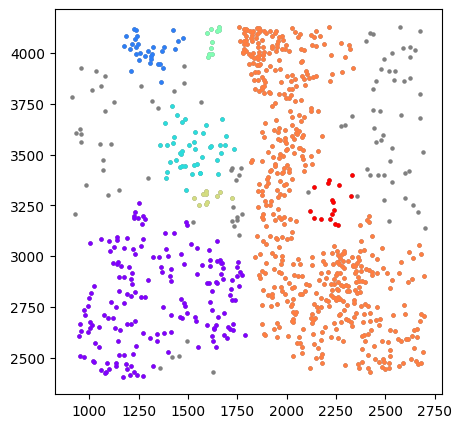

Pericytes


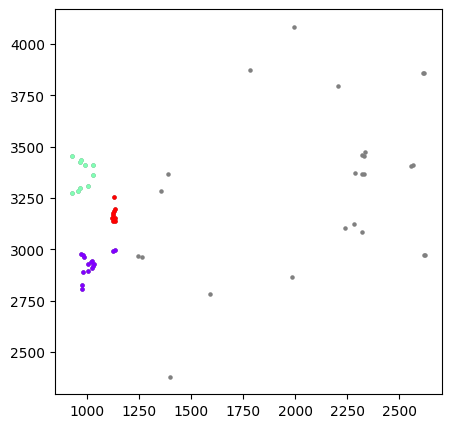

Ependymal


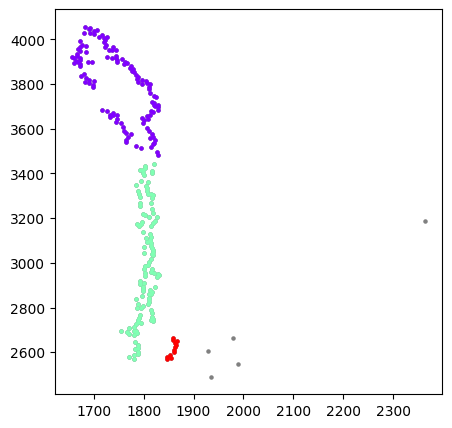

Microglia


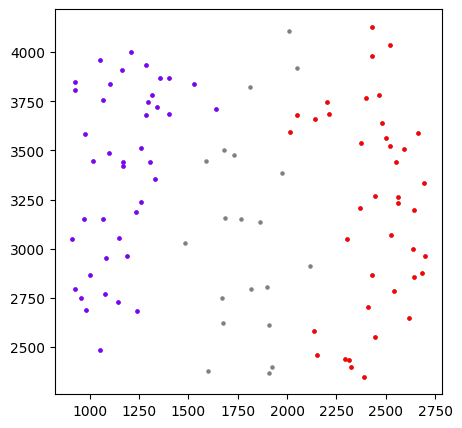

OD Mature 2


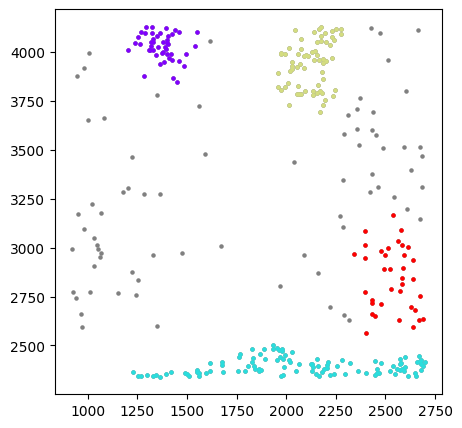

OD Immature 1


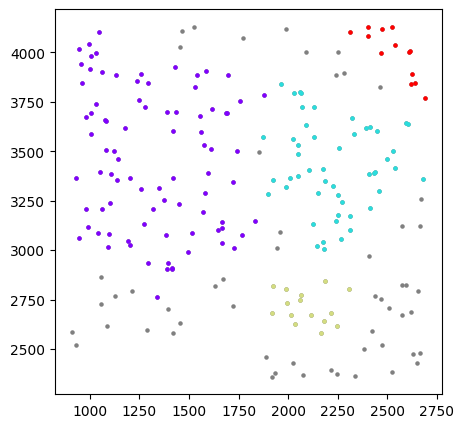

Endothelial 2


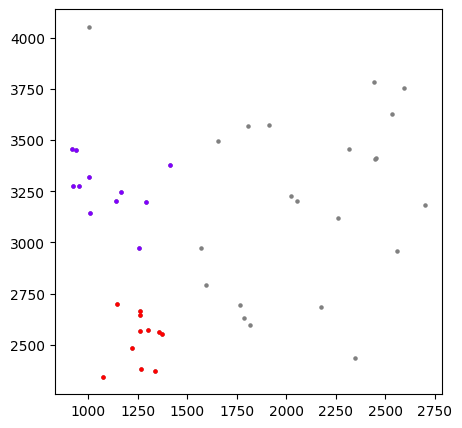

OD Mature 1


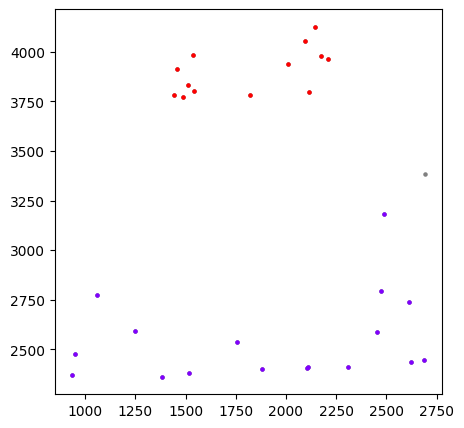

Ambiguous


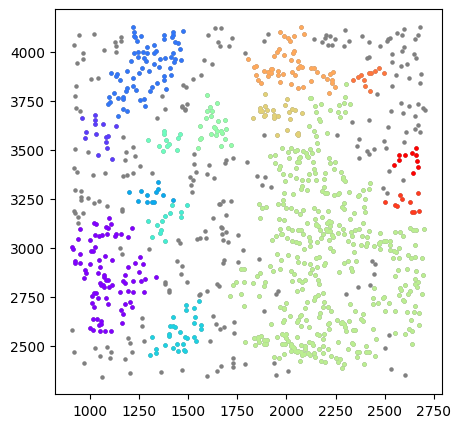

OD Immature 2


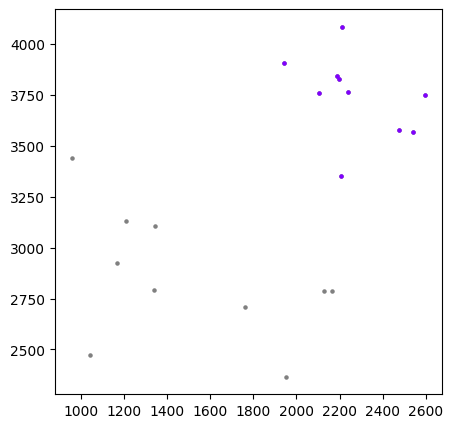

Astrocyte


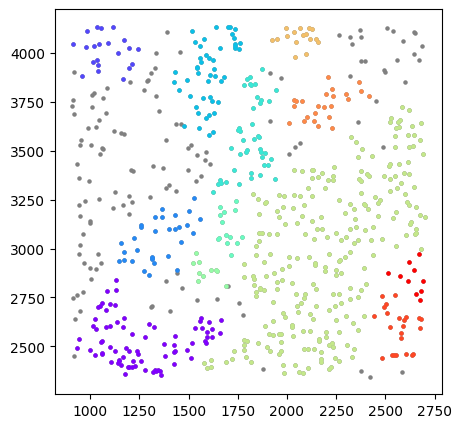

Endothelial 3


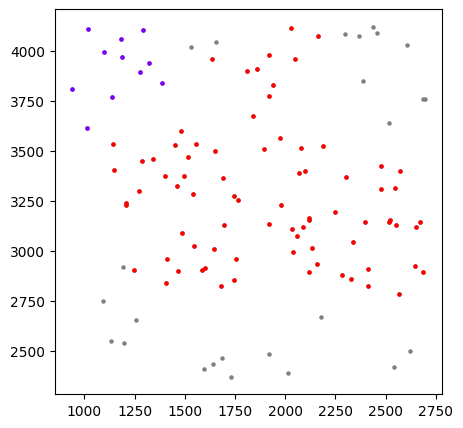

Endothelial 1


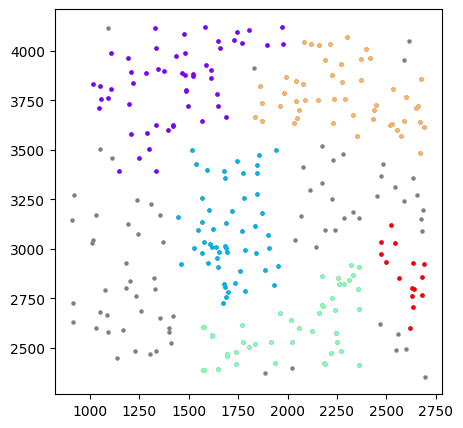

In [13]:
#visualization of DBSCAN clustering result
#legend: each dot is a cell, cells of the same color are from the same cluster, cells in the grey color are the noise identified by DBSCAN

sample_id = 'bregma_0.01'
sample_id = 'bregma_-0.09'
cluster_df = pd.DataFrame(np.load(datap+'output/clustering/'+sample_id+'_dbscan.cell.clusters.test2.npy',allow_pickle=True))
cluster_df.columns = ['cell_type','cell_idx']

meta_df_fov = pd.read_csv(datap+'data/merfish_'+sample_id+'.csv',index_col=0)
meta_df_fov.index = range(meta_df_fov.shape[0])
cell_type_l = list(set(cluster_df['cell_type']))
for ct in cell_type_l:
    print(ct)
    plt.figure(figsize=(5,5))
    #plot all ct cells
    meta_df_sel = meta_df_fov[meta_df_fov['Cell_class']==ct]
    X_sel = np.array(meta_df_sel[['Centroid_X','Centroid_Y']])
    plt.scatter(X_sel[:,0],X_sel[:,1],c = 'grey',s = 5)

    #higlight clusters for ct cells
    tmp_ct = cluster_df[cluster_df['cell_type']==ct]
    colors = cm.rainbow(np.linspace(0, 1, tmp_ct.shape[0]))

    for n,line in enumerate(tmp_ct['cell_idx']):
        X = np.array(meta_df_fov.loc[line][['Centroid_X','Centroid_Y']])
        plt.scatter(X[:,0],X[:,1],color =colors[n],s = 5)
    #plt.savefig(datap+'example/output/Figs/'+group+'_fov_'+str(fov)+"_"+ct+".cluster.pdf", dpi=100, tansparent=True)
    plt.show()

In [16]:
#ot
sample_id = 'bregma_0.01'
sample_id = 'bregma_-0.09'
meta_df_fov = pd.read_csv(datap+'data/merfish_'+sample_id+'.csv',index_col=0)
exp_df_norm = meta_df_fov.iloc[:,8:]
exp_df_norm = exp_df_norm[exp_df_norm>0]
df_quantile = exp_df_norm.quantile(q=0.99,axis = 0) 
known_lr_pairs = pd.read_csv(datap+'/data/lr_gene.list', header = 0, index_col = None, sep = '\t')
known_lr_pairs.columns = ['l_gene','r_gene']


cluster_df = pd.DataFrame(np.load(datap+'output/clustering/'+sample_id+'_dbscan.cell.clusters.test.npy',allow_pickle=True))
cluster_df.columns = ['cell_type','cell_idx']

#coordinates
meta_df_fov = pd.read_csv(datap+'data/merfish_'+sample_id+'.csv',index_col=0)
meta_df_fov['annotation']=meta_df_fov['Cell_class']
meta_df_fov.index = range(meta_df_fov.shape[0])

cell_id_all = np.array(range(meta_df_fov.shape[0]))
coord = np.array(meta_df_fov[['Centroid_X','Centroid_Y']])
S_all_arr = distance_matrix(coord,coord)

#expression
exp_df_fov = meta_df_fov.iloc[:,8:]
exp_df_fov = exp_df_fov/df_quantile
exp_df_fov[exp_df_fov>1]=1
exp_df_fov.index = cell_id_all

S_all_arr_new = scotia.sel_pot_inter_cluster_pairs(S_all_arr,cluster_df)

ga_df_final = scotia.source_target_ot(S_all_arr_new, exp_df_fov, meta_df_fov, known_lr_pairs)
if ga_df_final.shape[0]>0:
    ga_df_final.columns = ['source_cell_idx','receptor_cell_idx','likelihood','ligand_recptor','source_cell_type','target_cell_type']
    ga_df_final.to_csv(datap+'output/ot/'+sample_id+".ot.csv",header = True, index = False, sep = "\t")

    #post-processing of ot results by calculating averaged likelihoods
    ga_df_final['cell_pairs'] = ga_df_final['source_cell_type']+"_"+ga_df_final['target_cell_type']
    final_summary = scotia.post_ot(ga_df_final,label=sample_id)
    final_summary.to_csv(datap+'output/ot/summary/'+sample_id+".ot.csv",header = True, index = False, sep = "\t")




In [28]:
sample_id = 'bregma_0.01'
sample_id = 'bregma_-0.09'
df_ot = pd.read_csv(datap+'output/ot/summary/'+sample_id+'.ot.csv',header = 0, index_col = None, sep = '\t')
df_ot.columns = ['label','likelihood']
df_ot['lr_pairs'] = [x.split('|')[0] for x in df_ot['label']]
df_ot['cell_pairs'] = [x.split('|')[2] for x in df_ot['label']]
df_ot['ct1'] = [x.split('_')[0] for x in df_ot['cell_pairs']]
df_ot['ct2'] = [x.split('_')[1] for x in df_ot['cell_pairs']]
df_ot_sel = df_ot[(df_ot['ct1']=='Excitatory') & (df_ot['ct2'].isin(['Excitatory','Inhibitory']))]
df_ot_sel = df_ot_sel.sort_values('likelihood',ascending=False)
df_ot_sel = df_ot_sel[~df_ot_sel['lr_pairs'].isin(['Oxt_Avpr1a','Oxt_Avpr2'])]
df_ot_sel

,label,likelihood,lr_pairs,cell_pairs,ct1,ct2
115,Oxt_Oxtr|mouse2|Excitatory_Inhibitory,0.333102,Oxt_Oxtr,Excitatory_Inhibitory,Excitatory,Inhibitory
114,Ucn3_Crhr1|mouse2|Excitatory_Inhibitory,0.322205,Ucn3_Crhr1,Excitatory_Inhibitory,Excitatory,Inhibitory
128,Tac1_Tacr1|mouse2|Excitatory_Excitatory,0.174283,Tac1_Tacr1,Excitatory_Excitatory,Excitatory,Excitatory
109,Trh_Trhr|mouse2|Excitatory_Inhibitory,0.152788,Trh_Trhr,Excitatory_Inhibitory,Excitatory,Inhibitory
132,Ucn3_Crhr2|mouse2|Excitatory_Excitatory,0.149796,Ucn3_Crhr2,Excitatory_Excitatory,Excitatory,Excitatory
130,Oxt_Oxtr|mouse2|Excitatory_Excitatory,0.140496,Oxt_Oxtr,Excitatory_Excitatory,Excitatory,Excitatory
118,Tac1_Tacr3|mouse2|Excitatory_Inhibitory,0.111583,Tac1_Tacr3,Excitatory_Inhibitory,Excitatory,Inhibitory
111,Penk_Oprk1|mouse2|Excitatory_Inhibitory,0.108519,Penk_Oprk1,Excitatory_Inhibitory,Excitatory,Inhibitory
110,Tac1_Tacr1|mouse2|Excitatory_Inhibitory,0.108356,Tac1_Tacr1,Excitatory_Inhibitory,Excitatory,Inhibitory
133,Tac1_Tacr3|mouse2|Excitatory_Excitatory,0.102234,Tac1_Tacr3,Excitatory_Excitatory,Excitatory,Excitatory


In [29]:
df_tmp1 = pd.pivot(df_ot_sel[['lr_pairs','cell_pairs','likelihood']],index='lr_pairs',columns='cell_pairs')
df_tmp1.columns = [x[1] for x in df_tmp1.columns]
#df1_groupby2.index.name = 'donor'
df_tmp1.index.name = None
df_tmp1[np.isnan(df_tmp1)==True]=0
df_tmp1['ave'] = df_tmp1[['Excitatory_Excitatory','Excitatory_Inhibitory']].mean(axis=1)
df_tmp1 = df_tmp1.sort_values('ave',ascending=False)
df_tmp1 = df_tmp1.reset_index()
df_tmp1

,index,Excitatory_Excitatory,Excitatory_Inhibitory,ave
0,Oxt_Oxtr,0.140496,0.333102,0.236799
1,Ucn3_Crhr1,0.000000,0.322205,0.161103
2,Tac1_Tacr1,0.174283,0.108356,0.141320
3,Trh_Trhr,0.093850,0.152788,0.123319
4,Ucn3_Crhr2,0.149796,0.085211,0.117504
5,Tac1_Tacr3,0.102234,0.111583,0.106909
6,Pnoc_Oprl1,0.096003,0.099180,0.097591
7,Penk_Oprk1,0.000000,0.108519,0.054260
8,Penk_Oprd1,0.000000,0.099192,0.049596


<Axes: xlabel='index'>

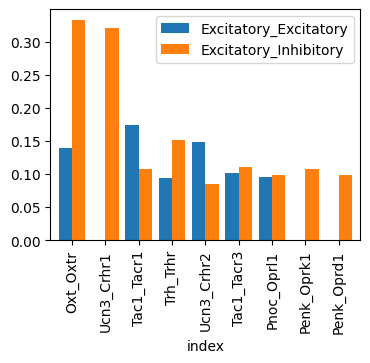

In [30]:
df_tmp1.iloc[:,:-1].plot(x = 'index',figsize=(4,3),kind='bar',width=0.8)

In [32]:
def read_data(file):
    try:
        df = pd.read_csv(file, header = 0, index_col=None, sep = "\t")
    except:
        df = pd.DataFrame()
    return df

a


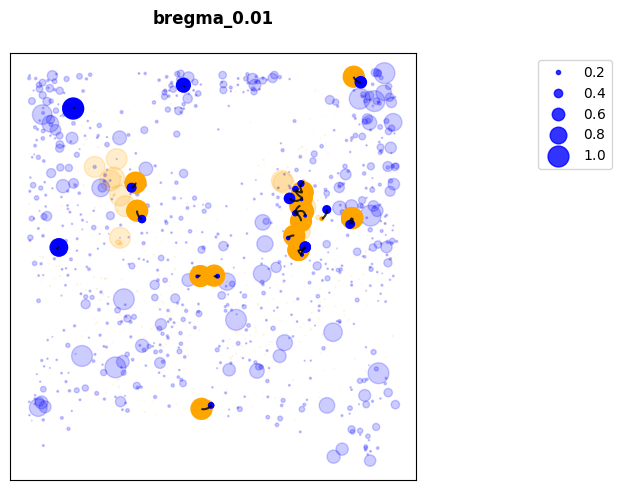

In [37]:
sample_id = 'bregma_0.01'
#sample_id = 'bregma_-0.09'
source_ct = 'Excitatory'
target_ct = ['Excitatory','Inhibitory']
l_gene = 'Oxt'
r_gene = 'Oxtr'


meta_df_fov = pd.read_csv(datap+'data/merfish_'+sample_id+'.csv',index_col=0)

exp_df_norm = meta_df_fov.iloc[:,8:]
exp_df_norm = exp_df_norm[exp_df_norm>0]
df_quantile = exp_df_norm.quantile(q=0.99,axis = 0) 

meta_df_fov.index = range(meta_df_fov.shape[0])


df_summary_tmp = read_data(datap+'output/ot/'+sample_id+".ot.csv")
if df_summary_tmp.shape[0]>0:
    print('a')
    df_sel = df_summary_tmp[df_summary_tmp['source_cell_type']==source_ct]
    df_sel = df_sel[df_sel['target_cell_type'].isin(target_ct)]
    df_sel = df_sel[df_sel['ligand_recptor']==l_gene+'_'+r_gene]
    if df_sel.shape[0]>0:
        exp_df_fov = meta_df_fov.iloc[:,8:]
        exp_df_fov = exp_df_fov/df_quantile
        exp_df_fov[exp_df_fov>1]=1
        exp_df_fov.index = range(meta_df_fov.shape[0])

        #idx
        l_id_sel = df_sel['source_cell_idx']
        r_id_sel = df_sel['receptor_cell_idx']
        #exp
        l_exp_sel = exp_df_fov.loc[l_id_sel][l_gene]
        r_exp_sel = exp_df_fov.loc[r_id_sel][r_gene]
        #coordinates
        l_pos = np.array(meta_df_fov.loc[l_id_sel][['Centroid_X','Centroid_Y']])
        r_pos = np.array(meta_df_fov.loc[r_id_sel][['Centroid_X','Centroid_Y']])



        l_id_all = meta_df_fov[meta_df_fov['Cell_class']==source_ct].index
        r_id_all = meta_df_fov[meta_df_fov['Cell_class'].isin(target_ct)].index
        l_exp_all = exp_df_fov.loc[l_id_all][l_gene]
        r_exp_all = exp_df_fov.loc[r_id_all][r_gene]
        l_uniq_pos = meta_df_fov.loc[l_id_all][['Centroid_X','Centroid_Y']].values
        r_uniq_pos = meta_df_fov.loc[r_id_all][['Centroid_X','Centroid_Y']].values


        plt.figure(figsize=(7,5))
        ax1 = plt.scatter(l_pos[:,0],l_pos[:,1],c = 'orange',s = (15*l_exp_sel)**2,label = l_gene,alpha = 1,zorder=2)
        ax2 = plt.scatter(r_pos[:,0],r_pos[:,1],c = 'blue',s = (15*r_exp_sel)**2,label = r_gene,alpha = 1,zorder=3)
        ax3 = plt.scatter(l_uniq_pos[:,0],l_uniq_pos[:,1],c = 'orange',s = (15*l_exp_all)**2,alpha = 0.2)
        ax4 = plt.scatter(r_uniq_pos[:,0],r_uniq_pos[:,1],c = 'blue',s = (15*r_exp_all)**2,alpha = 0.2)

        G = list(df_sel['likelihood'])
        ax = plt.gca()
        all_curves = scotia.curved_edges(l_pos,r_pos)
        for n,i in enumerate(list(range(l_pos.shape[0]))):
            #lc = LineCollection([all_curves[i]], colors='black',alpha = np.min([G[n]/np.quantile(G,q=0.8),1]), zorder=10)
            lc = LineCollection([all_curves[i]], colors='black',alpha = 0.8, zorder=10)
            ax.add_collection(lc)



        plt.title(sample_id+"\n",fontweight="bold")
        plt.tick_params(
            axis='both',         
            which='both',
            bottom=False,    
            left=False,  
            labelleft=False,
            labelbottom=False)
        kw = dict(prop="sizes", num=5,func=lambda s: np.sqrt(s)/15,color ='blue',alpha=0.8)
        plt.legend(*ax2.legend_elements(**kw),bbox_to_anchor=(1.5,1))
        plt.tight_layout()

        #plt.savefig(datap+'output/Figs/'+sample_id+'.spatial.pdf')
        plt.show()

In [46]:
#permutation test
it_n = 50
sample_id = 'bregma_-0.09'
c_t_1 = 'Excitatory'
c_t_2 = 'Inhibitory'

df_ot = pd.DataFrame([])
df_permu = pd.DataFrame([])

compare_dic ={}

#for fov in set(meta_df['fov']):
meta_df_fov = pd.read_csv(datap+'data/merfish_'+sample_id+'.csv',index_col=0)
df_ot_tmp = read_data(datap+'output/ot/summary/'+sample_id+'.ot.csv')#final 

if df_ot_tmp.shape[0]>0:
    df_ot = pd.concat([df_ot,df_ot_tmp])

#import permutation result
df_permu_tmp = read_data(datap+'output/permutation/summary/'+sample_id+'.permu.csv')
if df_permu_tmp.shape[0]>0:
    df_permu = pd.concat([df_permu,df_permu_tmp])
        
df_ot['lr_pairs'] = [x.split('|')[0] for x in df_ot['label']]
df_ot['cell_pairs'] = [x.split('|')[2] for x in df_ot['label']]  

df_permu['it_n'] = [x.split('|')[-1] for x in df_permu['label']]
df_permu['lr_pairs'] = [x.split('|')[0] for x in df_permu['label']]
df_permu['label_new'] = df_permu['lr_pairs']+"|"+df_permu['it_n'].map(str)
df_permu['cell_pairs'] = [x.split('|')[2] for x in df_permu['label']]
c_t_p = c_t_1+"_"+c_t_2
df_ot_tmp = df_ot[df_ot['cell_pairs'] == c_t_p]
df_permu_tmp = df_permu[df_permu['cell_pairs'] == c_t_p]

if df_permu_tmp.shape[0]>0:
    df_ot_groupby = df_ot_tmp.groupby(['label'])['ave_likelihood'].sum().to_frame().reset_index()
    df_ot_groupby.index = [x.split('|')[0] for x in df_ot_groupby['label']]
    df_permu_groupby = df_permu_tmp.groupby(['label_new'])['ave_likelihood'].sum()

    for i in df_ot_groupby.index:
        compare_dic[i+"|"+sample_id+"|"+c_t_p] = 0
        df_permu_groupby_sel = df_permu_groupby[df_permu_groupby.index.str.contains(i+"\|")]
        for j in df_permu_groupby_sel:
            if j > df_ot_groupby.loc[i,'ave_likelihood']:
                compare_dic[i+"|"+sample_id+"|"+c_t_p] += 1/it_n
                        
p_l = [round(x,3) for x in compare_dic.values()]
pvalue_adj = multipletests(p_l, alpha=0.05, method='fdr_bh')[1]
pvalue_adj = [round(x,3) for x in pvalue_adj]

In [48]:
compare_dic

{'Oxt_Avpr1a|bregma_-0.09|Excitatory_Inhibitory': 0.04,
 'Oxt_Avpr2|bregma_-0.09|Excitatory_Inhibitory': 0.06,
 'Oxt_Oxtr|bregma_-0.09|Excitatory_Inhibitory': 0,
 'Penk_Oprd1|bregma_-0.09|Excitatory_Inhibitory': 0.3,
 'Penk_Oprk1|bregma_-0.09|Excitatory_Inhibitory': 0.4000000000000001,
 'Pnoc_Oprl1|bregma_-0.09|Excitatory_Inhibitory': 0.7600000000000003,
 'Tac1_Tacr1|bregma_-0.09|Excitatory_Inhibitory': 0.3,
 'Tac1_Tacr3|bregma_-0.09|Excitatory_Inhibitory': 0.6200000000000002,
 'Trh_Trhr|bregma_-0.09|Excitatory_Inhibitory': 0.36000000000000004,
 'Ucn3_Crhr1|bregma_-0.09|Excitatory_Inhibitory': 0,
 'Ucn3_Crhr2|bregma_-0.09|Excitatory_Inhibitory': 0.27999999999999997}